In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
import sys
sys.path.insert(0, 'C:\\Users\\gauthieca\\Desktop\\Code_ Thèse\\bandits-to-rank')
sys.path.insert(0, '~/Desktop/louis_vuitton/code/bandits-to-rank')


### Packages

In [35]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import time

from bandits_to_rank.sampling.metropolis_hasting import *
from bandits_to_rank.sampling.proposal import *
from bandits_to_rank.sampling.target import *
from bandits_to_rank.data.Methode_Simulation_KappasThetasKnown import *
from scipy.special import expit

from bandits_to_rank.bandits import *
from bandits_to_rank.environment import *
from bandits_to_rank.referee import *
from bandits_to_rank.opponents import oracle, random_player


from random import uniform
from copy import deepcopy

%matplotlib inline
%precision 4

plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial

In [36]:
def time_sec_to_HMS(sec):
    heure=sec//3600
    rest_h=sec%3600
    minute=rest_h//60
    rest_m=rest_h%60

    return(str(int(heure))+'H '+str(int(minute))+'min '+str(int(rest_m))+'sec')

# Proposal distribution

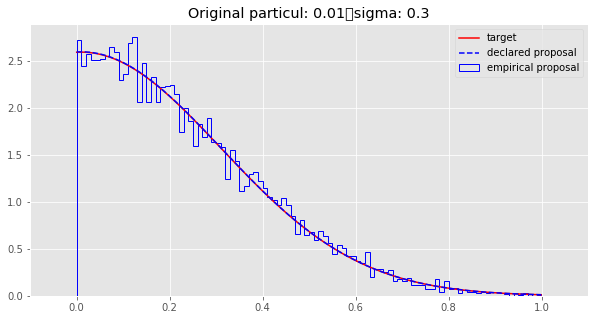

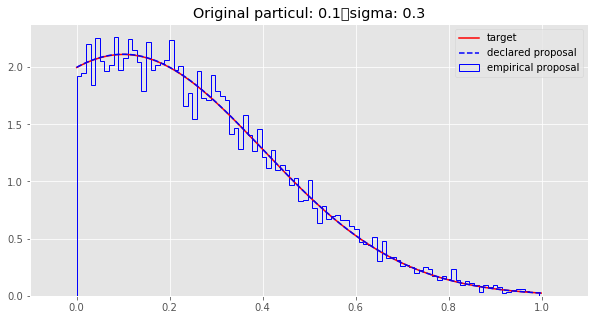

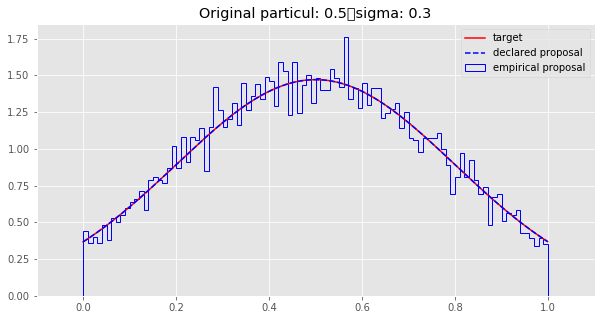

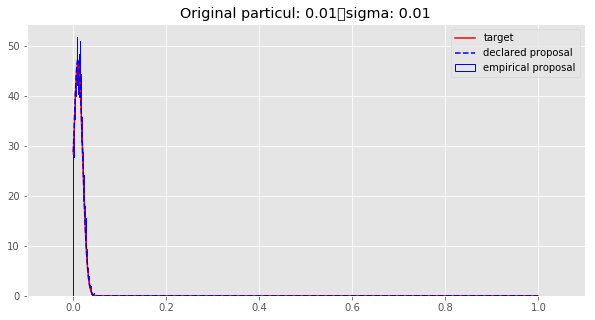

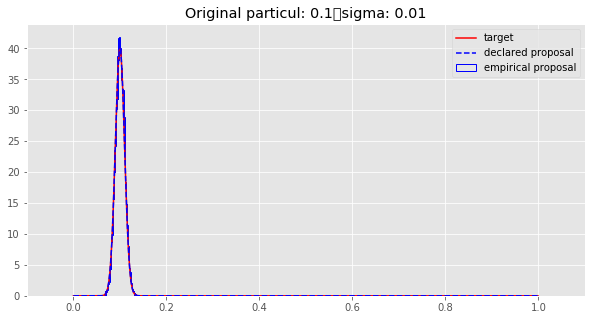

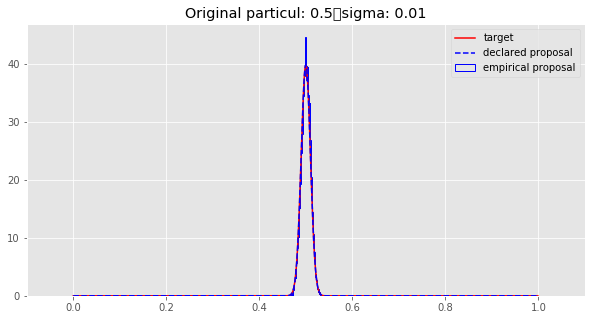

In [19]:
for sigma in [0.3, 0.01]:
    proposal = TruncatedGaussianRandomWalk(a=0, b=1, sigma=sigma, k=0, on_theta=True)
    for prev_part in [0.01, 0.1, 0.5]:

        plt.figure(figsize=(10, 5))
        plt.title('Original particul: '+ str(prev_part) + '\tsigma: ' + str(sigma))

        ###Fig Densité

        # targeted proposal
        x = np.arange(0.00000001, 1, 0.001)
        log_y = st.norm.logpdf(x, loc=prev_part, scale=sigma)
        log_y -= max(log_y)
        y_true = np.exp(log_y) / sum(np.exp(log_y)) * len(x)
        #print(max(log_y), sum(np.exp(log_y)))
        #print(y_true)
        plt.plot(x, y_true, color='red', label='target')

        # declared proposal
        x = np.arange(0.00000001, 1, 0.001)
        log_y = np.zeros(len(x))
        for i in range(len(x)):
            log_y[i] = proposal.logpdf([[prev_part],[]], [[x[i]],[]])
        y_prop = np.exp(log_y)
        #print(y_prop)
        plt.plot(x, y_prop, color='b',linestyle ='--', label='declared proposal')

        # empirical proposal
        n = 10000
        x = np.zeros(n)
        for i in range(n):
            next_part = proposal.next_part([[prev_part],[]])
            x[i] = next_part[0][0]
        plt.hist(x, 100 ,histtype='step',color = 'b', density=True, linewidth=1, label='empirical proposal')

        plt.legend()
        plt.xlim([-0.1,1.1]);
        #plt.yscale('log')








# in use with MH

### Test 5 Theta/5 kappa

In [20]:
thetas = [0.9, 0.7 ,0.2 ,0.2 ,0.1 ]
#thetas_bis = [round(gauss(0.4,0.05),2) for i in range(100)]
kappas = [1,0.9,0.7,0.5,0.2] ### attention c'est peut etre trop facile s'il y en a à 1 => ok parce que Simul
n = 100

dict_multi = Simulation(n,thetas,kappas)
print(dict_multi['success'][0][0])
print(dict_multi['fail'])

21.0
[[ 2.  2.  7. 11. 15.]
 [ 8.  3.  6. 12. 15.]
 [11. 19. 21. 12. 16.]
 [12. 20. 16. 19. 22.]
 [16. 18. 15. 23. 17.]]


In [21]:
dict_multi['max_seen']

array([0., 4., 2., 1., 3.])

In [22]:
part0 = [np.array([uniform(0, 1) for i  in range(len(thetas))]),
         np.array([1]+[uniform(0, 1) for i  in range(1,len(kappas))])]
print (part0)
part0_logit = part0+[np.array([expit(a) for a  in part0[0]]),  np.array([(np.inf)]+[expit(a) for a  in part0[1]])]
print (part0_logit)

[array([0.7015, 0.5789, 0.9549, 0.6981, 0.9529]), array([1.    , 0.2446, 0.0477, 0.6032, 0.4311])]
[array([0.7015, 0.5789, 0.9549, 0.6981, 0.9529]), array([1.    , 0.2446, 0.0477, 0.6032, 0.4311]), array([0.6685, 0.6408, 0.7221, 0.6678, 0.7217]), array([   inf, 0.7311, 0.5609, 0.5119, 0.6464, 0.6061])]


In [23]:
part0_good_kappa = [np.array(part0[0]), np.array(kappas)]
part0_good_kappa

[array([0.7015, 0.5789, 0.9549, 0.6981, 0.9529]),
 array([1. , 0.9, 0.7, 0.5, 0.2])]

## On All

In [24]:
proposals_MA_all = [TruncatedGaussianRandomWalk(on_theta=True, k=i) for i in range(part0[0].shape[0])] + [TruncatedGaussianRandomWalk(on_theta=False, k=i) for i in range(1, part0[1].shape[0])]
targets_all = [Target(dict_multi, i) for i in range(part0[0].shape[0])] + [Target(dict_multi, k=i,on_theta=False) for i in range(1,part0[1].shape[0])]


In [25]:
%time samples_MA_all,eff_MA = log_Metro_hast (proposals_MA_all,targets_all, part0, 1000, True )

CPU times: user 3.48 s, sys: 28.6 ms, total: 3.51 s
Wall time: 3.58 s


In [26]:
print ('MA, ', eff_MA)


MA,  [0.281 0.278 0.237 0.271 0.246 0.351 0.408 0.368 0.364 0.   ]


In [27]:
thetas_MH_MA_all , kappas_MH_MA_all = split_sample(samples_MA_all)

In [28]:
#### Definition des particules pour tracer les densité
pas = 400
thetas_plot = np.array([i*np.ones(len(thetas)) for i in np.linspace(0, 1, pas) ])

particules = []
for i in range(pas) :
    particules.append([thetas_plot[i], np.array(kappas)])
particules_plot = np.array(particules)

#####

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


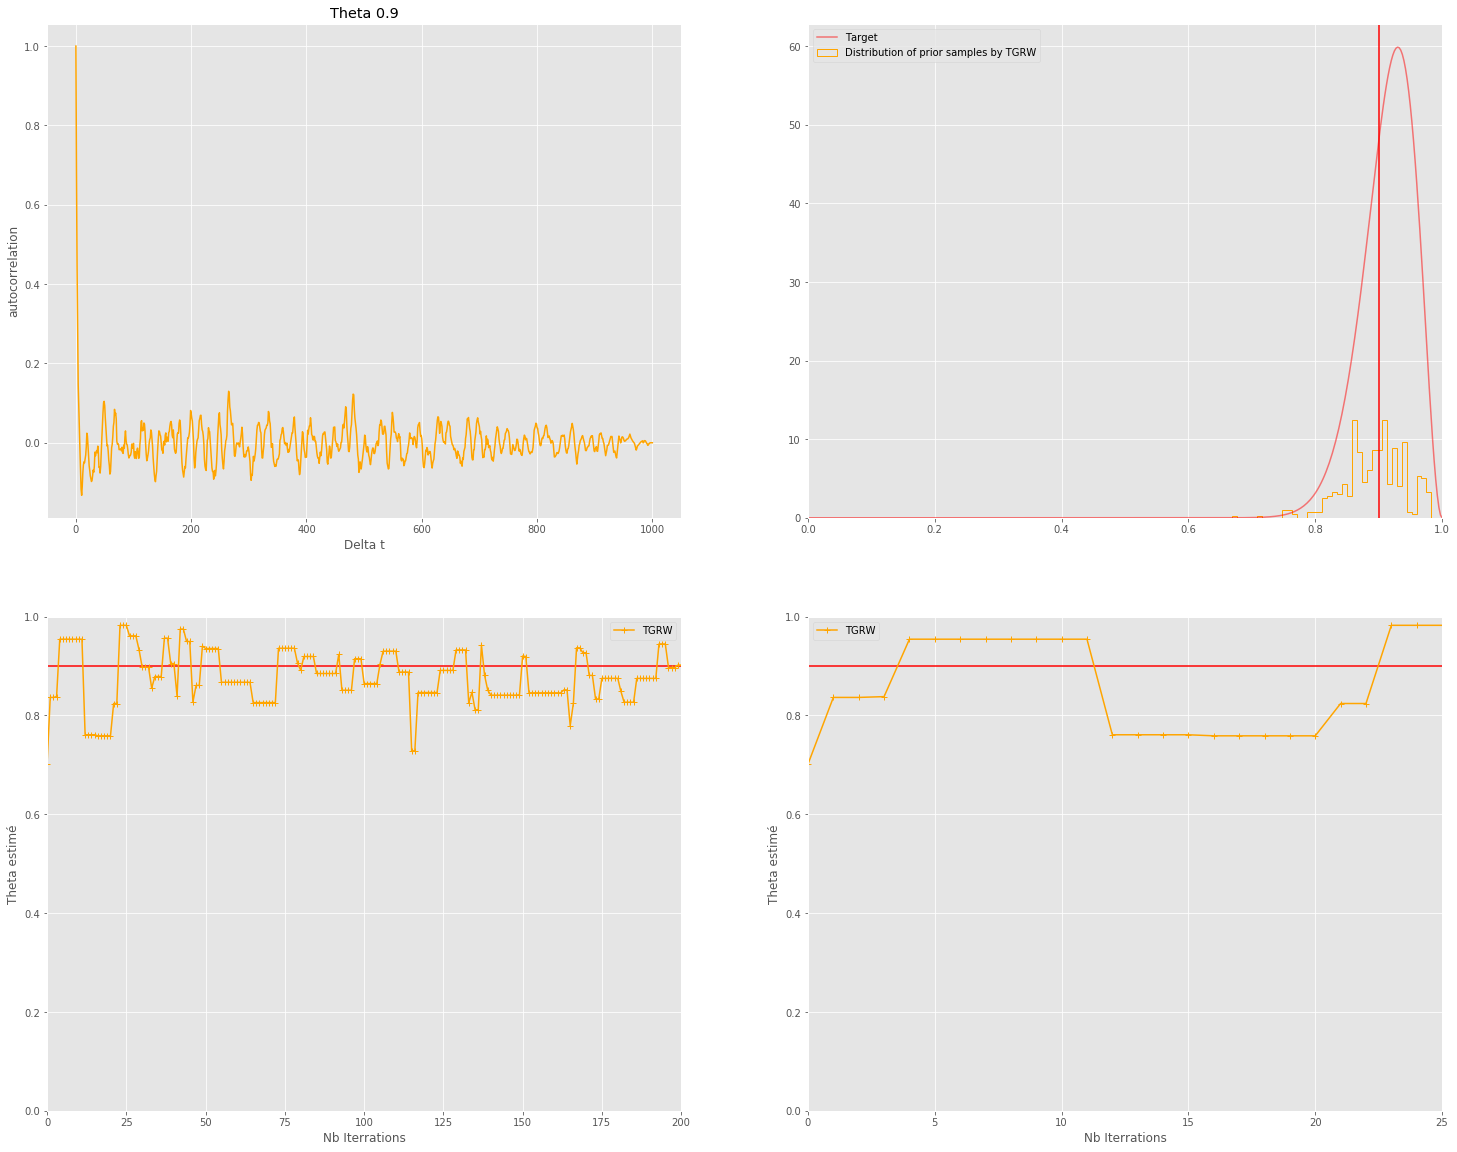

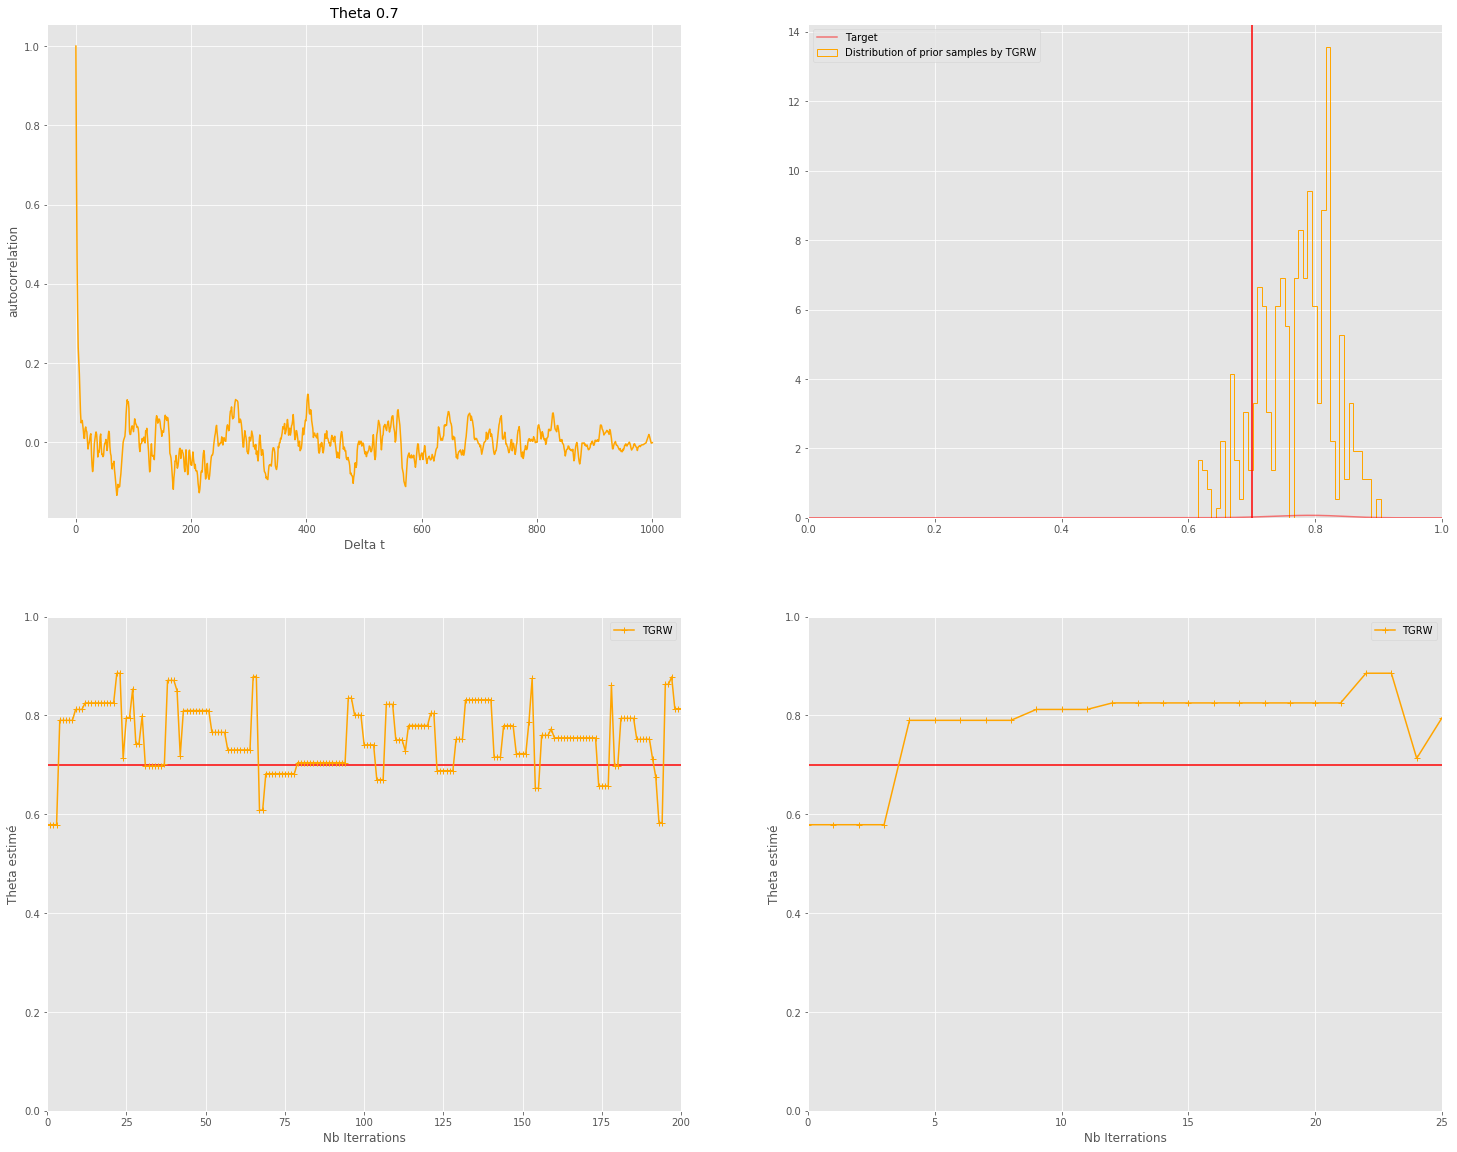

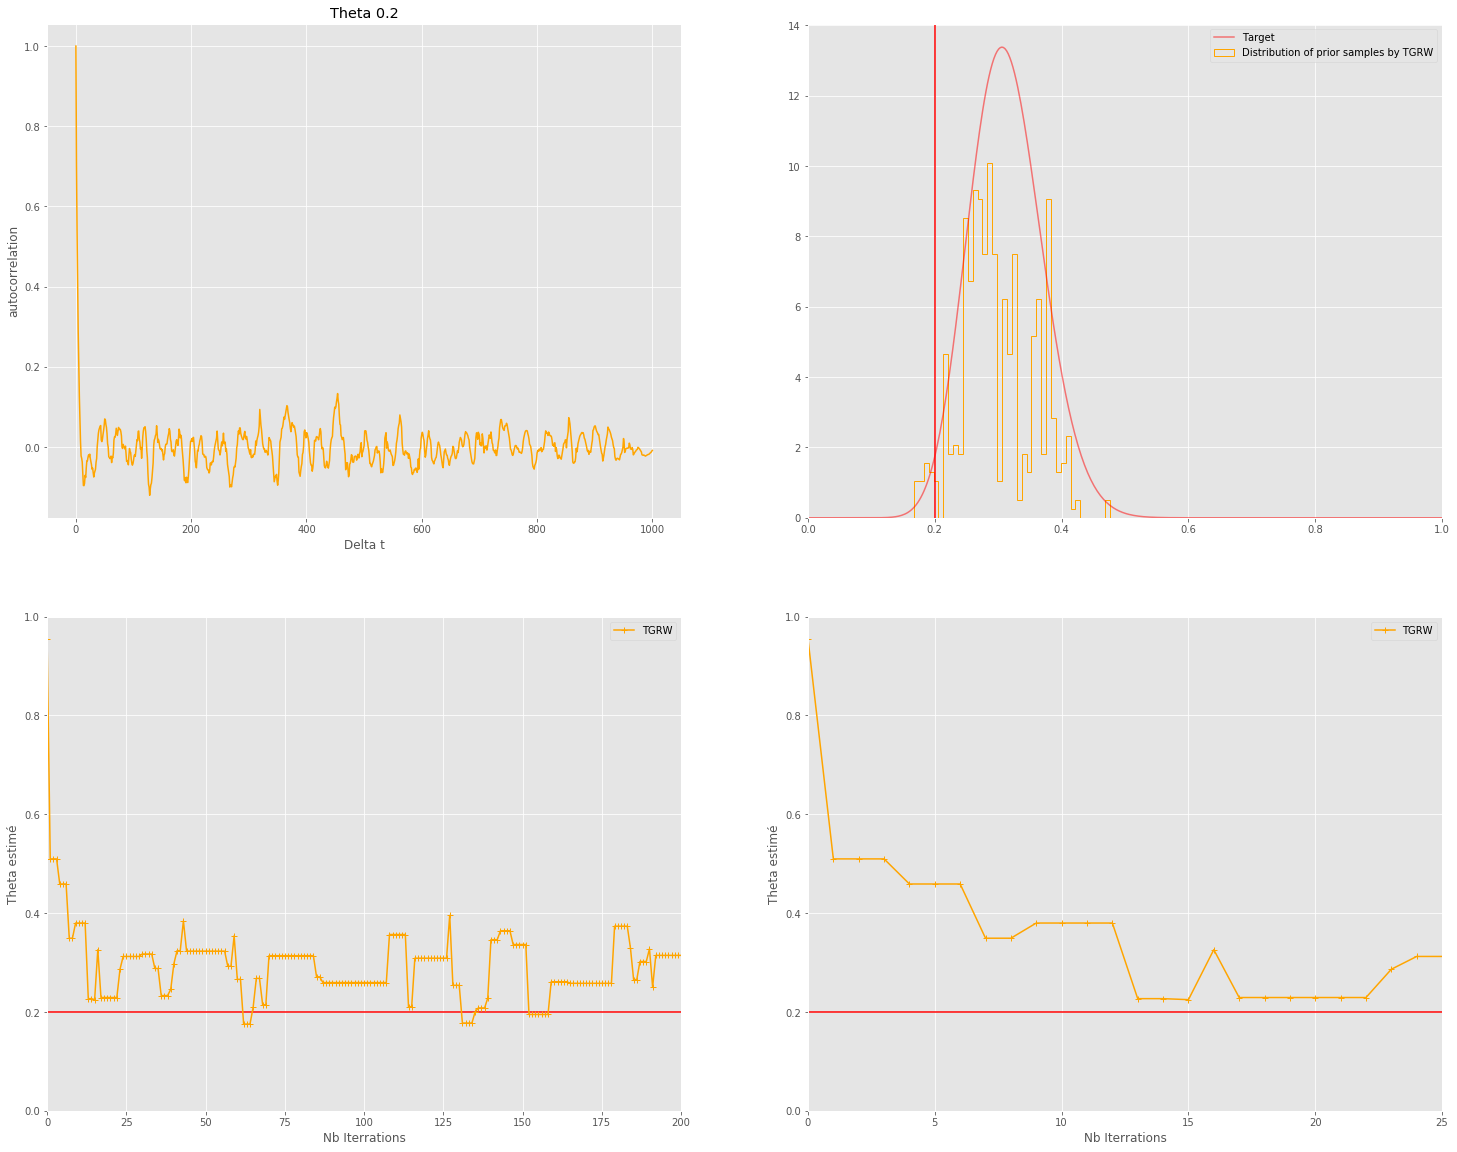

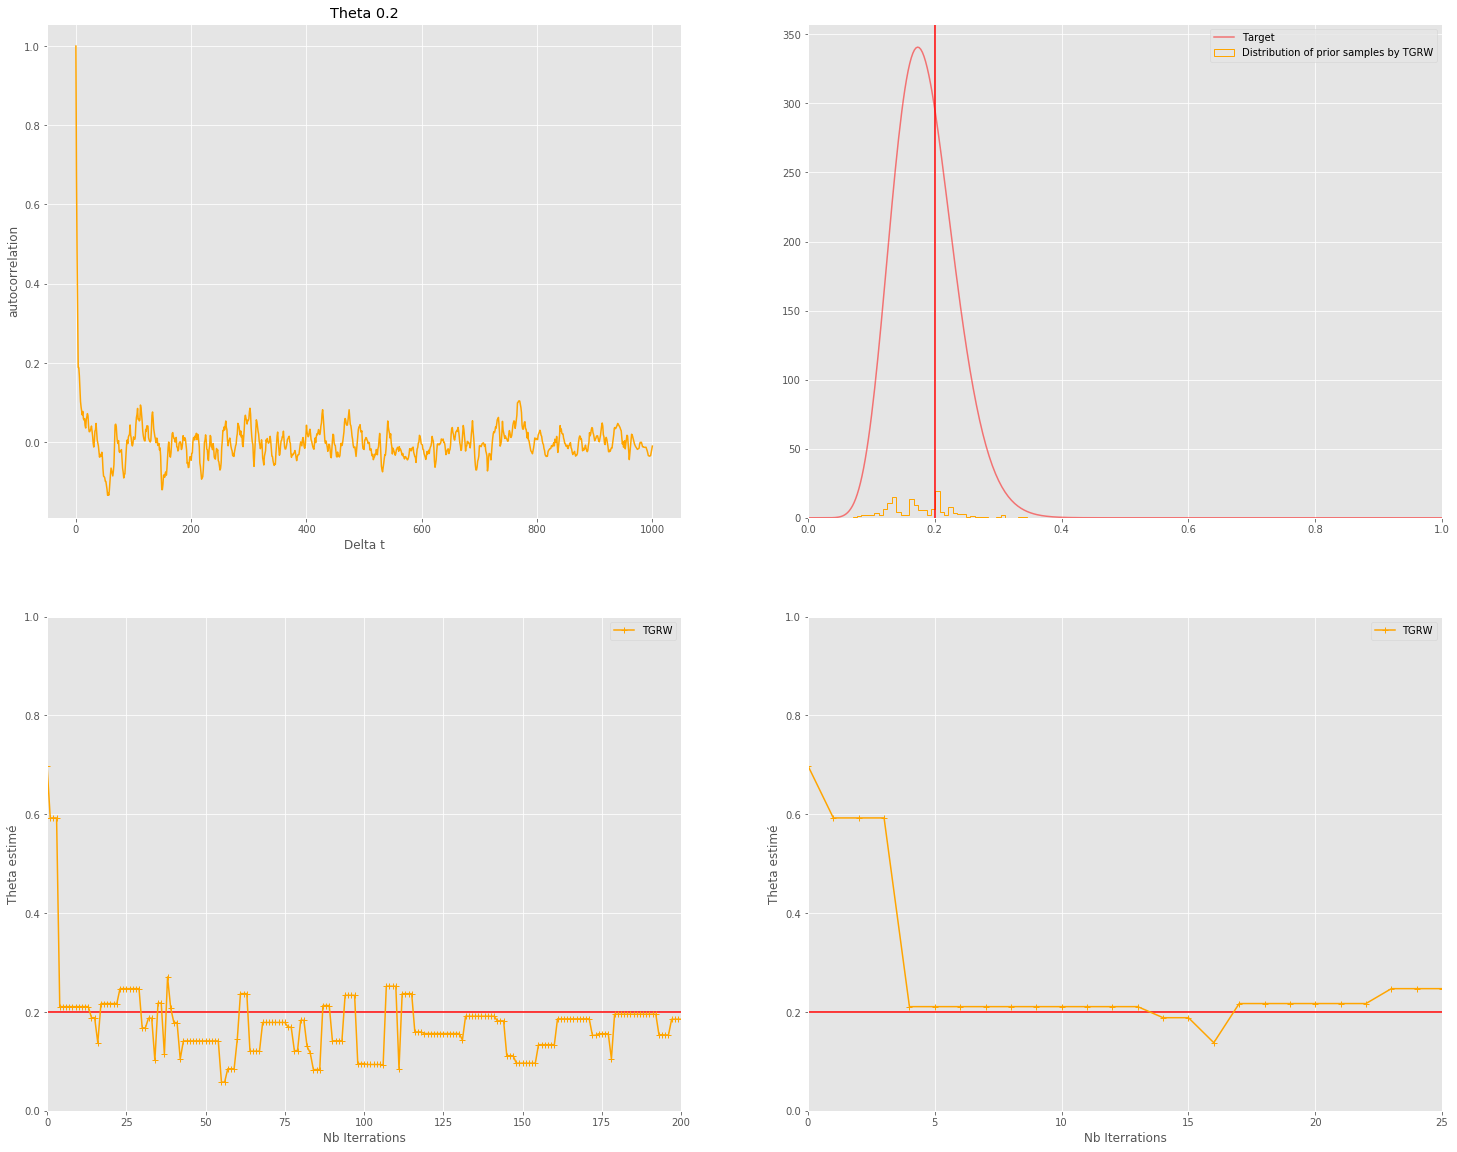

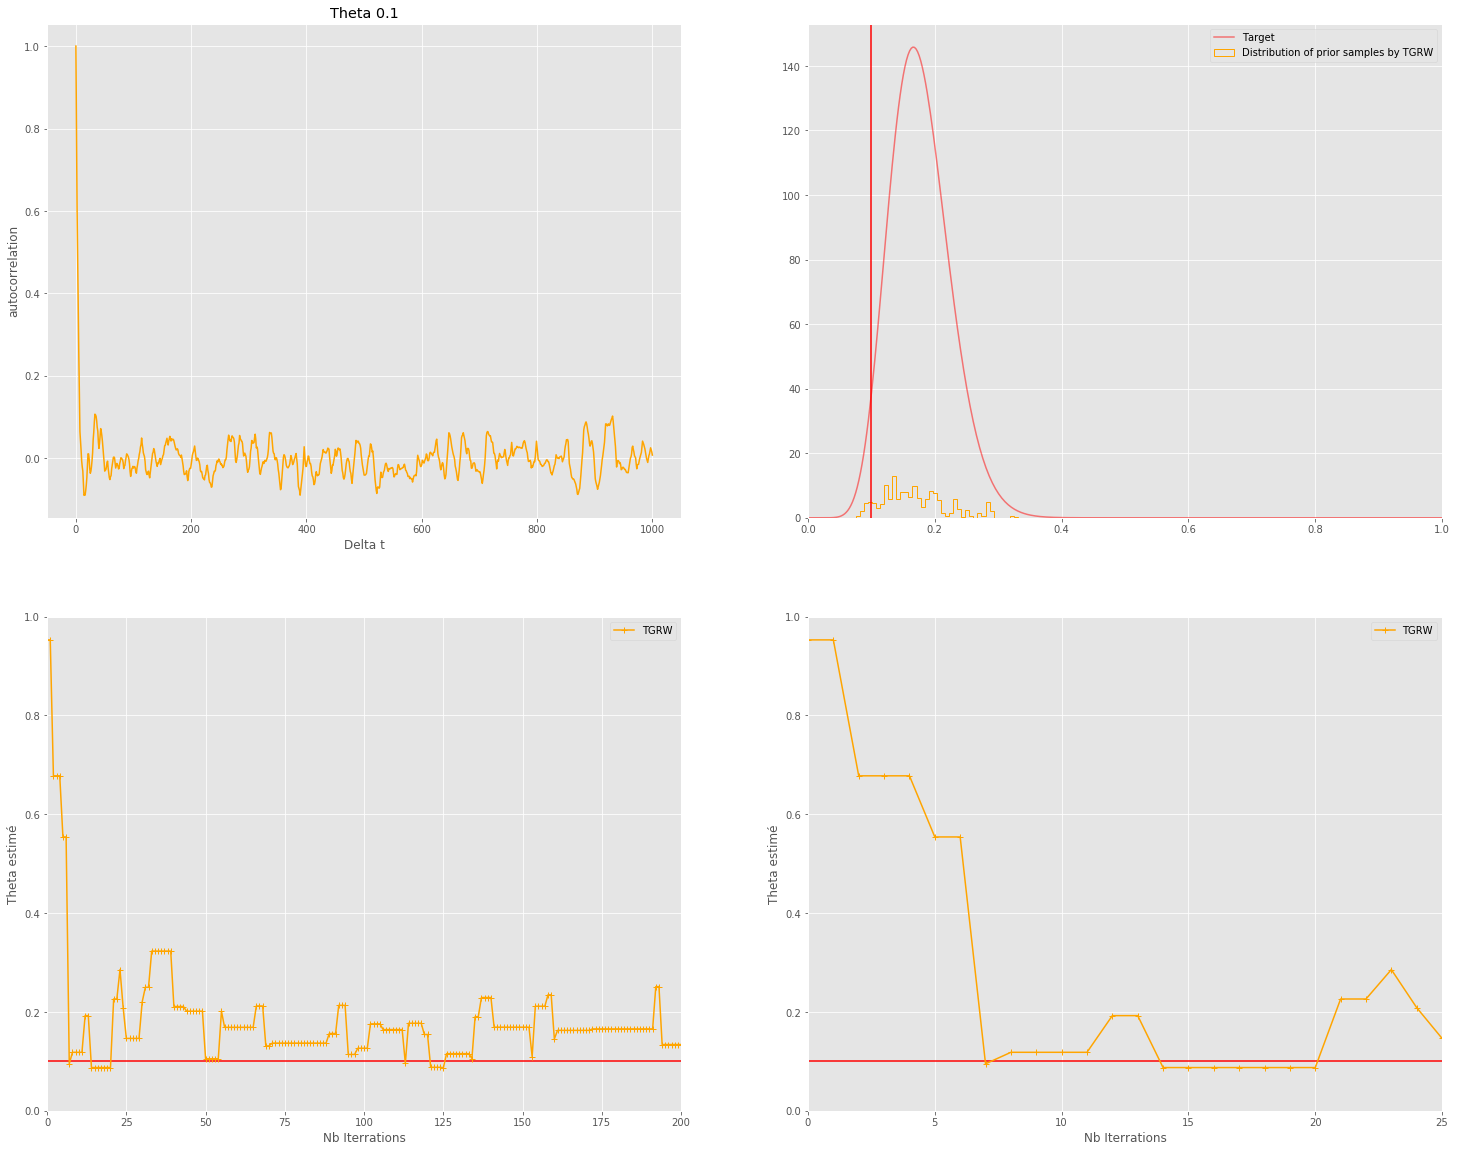

In [29]:
nmcmc = len(thetas_MH_MA_all[0])//2

for i in range(part0[0].shape[0]):
    plt.figure(figsize=(25, 20))
    plt.title('Theta '+str(thetas[i]))
    ###Fig Autocor
    plt.subplot(2,2,1)
    plt.title('Theta '+str(thetas[i]))
    notrend_samples_MA_theta = detrend(np.array(thetas_MH_MA_all[i]))
    cor = acf(notrend_samples_MA_theta,nlags=1000)
    plt.plot(cor, c ='orange', label ='TGRW')
    plt.ylabel("autocorrelation")
    plt.xlabel("Delta t")
    
    
    
    ###Fig Densité
    
    plt.subplot(2,2,2)

    plt.axvline(x=thetas[i], color='r')
    
       
    X_Target_theta3, Y_Target_theta3 = targets_all[i].pdf_multiparticule(particules_plot)
    
    plt.plot(X_Target_theta3, Y_Target_theta3, c='red', linestyle='-', alpha=0.5, label='Target')

    
    plt.hist(thetas_MH_MA_all[i][nmcmc:], 40 ,histtype='step',color = 'orange', density=True, linewidth=1, label='Distribution of prior samples by TGRW');

    plt.legend()
    plt.xlim([0,1]);

    
    ###Fig Chemin Particule long
    
    plt.subplot(2,2,3)
    #plt.title('Theta '+ str(thetas[i]))
    plt.axhline(y=thetas[i], color='r')
    plt.plot(np.array(thetas_MH_MA_all[i]), '-+',c='orange', label='TGRW')
    plt.xlim([0, 200])
    plt.ylim([0, 1]);
    plt.legend()
    plt.xlabel("Nb Iterrations")
    plt.ylabel("Theta estimé")
    
    ###Fig Chemin Particule court
    
    plt.subplot(2,2,4)
    #plt.title('Theta '+ str(thetas[i]))
    plt.axhline(y=thetas[i], color='r')
    plt.plot(np.array(thetas_MH_MA_all[i]), '-+',c='orange', label='TGRW')
    plt.xlim([0, 25])
    plt.ylim([0, 1]);
    plt.legend()
    plt.xlabel("Nb Iterrations")
    plt.ylabel("Theta estimé")

# In use with MH in bandit context

In [33]:
# Environment

kappas = [1,0.7,0.3,0.75,0.1]
thetas = [0.9,0.3,0.5,0.4,0.1,0.2,0.5,0.1,0.8,0.4]
nb_prop = len(thetas)  
nb_place = len(kappas)

env = Environment_PBM(thetas,kappas)


# Games
nb_trial = 5000
nb_game = 2

In [45]:
c = 0.1
pas = 1

referee_TSMH_kappa_desord_01  = Referee(env,nb_trial)

start = time.time()  
for i in range(nb_game):
    part0 = [np.array([uniform(0, 1) for i  in range(nb_prop)]), np.array([1]+[uniform(0, 1) for i  in range(1,nb_place)])]
    player = TS_MH_kappa_desordonne(nb_prop,nb_place,part0,pas,c)
    referee_TSMH_kappa_desord_01.play_game(player)
end = time.time()   
print ('time :',time_sec_to_HMS(end-start)) 

time : 0H 1min 21sec


In [48]:
c = 10
pas = 1

referee_TSMH_kappa_desord_10  = Referee(env,nb_trial)

start = time.time()  
for i in range(nb_game):
    part0 = [np.array([uniform(0, 1) for i  in range(nb_prop)]), np.array([1]+[uniform(0, 1) for i  in range(1,nb_place)])]
    player = TS_MH_kappa_desordonne(nb_prop,nb_place,part0,pas,c)
    referee_TSMH_kappa_desord_10.play_game(player)
end = time.time()   
print ('time :',time_sec_to_HMS(end-start)) 

time : 0H 0min 54sec


In [49]:
c = 1000
pas = 1

referee_TSMH_kappa_desord_1000  = Referee(env,nb_trial)

start = time.time()  
for i in range(nb_game):
    part0 = [np.array([uniform(0, 1) for i  in range(nb_prop)]), np.array([1]+[uniform(0, 1) for i  in range(1,nb_place)])]
    player = TS_MH_kappa_desordonne(nb_prop,nb_place,part0,pas,c)
    referee_TSMH_kappa_desord_1000.play_game(player)
end = time.time()   
print ('time :',time_sec_to_HMS(end-start)) 

time : 0H 1min 15sec


In [50]:
c = 10000
pas = 1

referee_TSMH_kappa_desord_10000  = Referee(env,nb_trial)

start = time.time()  
for i in range(nb_game):
    part0 = [np.array([uniform(0, 1) for i  in range(nb_prop)]), np.array([1]+[uniform(0, 1) for i  in range(1,nb_place)])]
    player = TS_MH_kappa_desordonne(nb_prop,nb_place,part0,pas,c)
    referee_TSMH_kappa_desord_10000.play_game(player)
end = time.time()   
print ('time :',time_sec_to_HMS(end-start)) 

time : 0H 4min 58sec


In [37]:
referee_Oracle = Referee(env,nb_trial)

start = time.time()
for i in range(nb_game):
    player = oracle.Oracle(env.get_best_index())
    referee_Oracle.play_game(player)
end = time.time()   

print ('time :',time_sec_to_HMS(end-start)) 

time : 0H 0min 0sec


In [41]:
referee_Random = Referee(env,nb_trial)

start = time.time()  
for i in range(nb_game):
    player = random_player.Random(nb_prop,nb_place)
    referee_Random.play_game(player)
end = time.time()   

print ('time :',time_sec_to_HMS(end-start)) 

time : 0H 0min 0sec


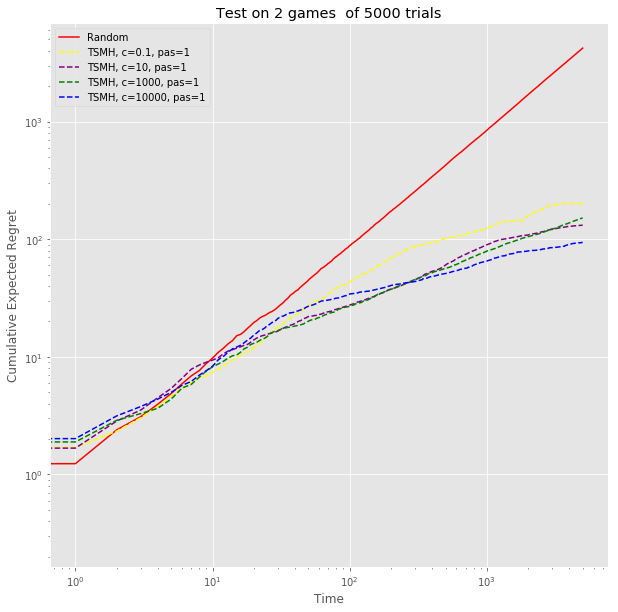

In [52]:
trials = [i for i in range(referee_Oracle.nb_trials)]

plt.figure(figsize=(10, 10))

#plt.plot(trials, np.cumsum(referee_Oracle.get_regret_expected(), axis=0)[trials], color = 'black', label='Oracle')
plt.plot(trials, np.cumsum(referee_Random.get_regret_expected(), axis=0)[trials], color = 'r', label='Random')
plt.plot(trials, np.cumsum(referee_TSMH_kappa_desord_01.get_regret_expected(), axis=0)[trials], color = 'yellow', linestyle = '--', label = 'TSMH, c=0.1, pas=1')
plt.plot(trials, np.cumsum(referee_TSMH_kappa_desord_10.get_regret_expected(), axis=0)[trials], color = 'purple', linestyle = '--', label = 'TSMH, c=10, pas=1')
plt.plot(trials, np.cumsum(referee_TSMH_kappa_desord_1000.get_regret_expected(), axis=0)[trials], color = 'green', linestyle = '--', label = 'TSMH, c=1000, pas=1')
plt.plot(trials, np.cumsum(referee_TSMH_kappa_desord_10000.get_regret_expected(), axis=0)[trials], color = 'blue', linestyle = '--', label = 'TSMH, c=10000, pas=1')

plt.xlabel('Time')
plt.ylabel('Cumulative Expected Regret')
plt.title ('Test on '+ str(nb_game) + ' games  of '+ str(nb_trial)+' trials')
plt.legend()
plt.grid(True)
plt.loglog()
plt.show()